In [11]:
#import datetime as dt
#dt.datetime.strptime(yearmonth, '%Y %B')
#can't use this to find difference in terms of months: "-92 days, 0:00:00" 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#difference expressed in months, for y-axis
def dateToNum(yearmonth):
    months = { "January" : 0, "February" : 1, "March" : 2, "April" : 3, "May" : 4,
                "June" : 5, "July" : 6, "August" : 7, "September" : 8, "October" : 9,
                "November" : 10, "December" : 11 }
    if(pd.isna(yearmonth)):
        return yearmonth;   #self.value = NaN?
    #else: 
    inputarray = yearmonth.split(" ")
    return int(inputarray[0])*12 + months[inputarray[1]]

def numToDate(number, lossless = True):
    months_names = { 0: "January", 1: "February", 2: "March", 3: "April", 4: "May",
                    5: "June", 6: "July", 7: "August", 8: "September", 9: "October",
                    10: "November", 11: "December" }
    if(lossless):
        return str(int(number/12)) + " " + months_names[number % 12]
    else:
        return str(int(number/12))

#list of Foreigner Indoor/Outdoor Revenue Service positions at Kiaochow in surveyed period
customsData = pd.read_csv("customs research (version 1).csv")

#change name strings to my year-month objects
years = ["1901", "1906"]
promoData = []
for i in years:
    promos = customsData[~pd.isna(customsData[i + " date promoted to primary"])]
    if(i == "1906"):
        promos = promos[promos["1901 date promoted to primary"] != promos["1906 date promoted to primary"]]
    dateCols = ["first hired", i + " date promoted to primary", i + " date promoted to secondary"]
    for col in dateCols:
        promos.loc[:,col] = promos.loc[:,col].apply(dateToNum)
    promoData.append(promos)

#A value is trying to be set on a copy of a slice from a DataFrame.
#Try using .loc[row_indexer,col_indexer] = value instead
promoData[0].loc[:,"1901 promotion wait"] = np.subtract(
    promoData[0]["1901 date promoted to primary"], promoData[0]["first hired"])
promoData[1].loc[:,"1906 promotion wait"] = np.subtract(
    promoData[1]["1906 date promoted to primary"], promoData[1]["first hired"])


C:\Users\boopa\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\boopa\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [12]:
from scipy import stats

class GraphAndTest:
    def __init__(self, data, x="promodate", y="careerlength", hue="year", ax_rank="Current Rank"):                
        self.data = data
        self.hue = hue
        self.x = x
        self.y = y
        self.graph = sns.JointGrid(data = data,
            x = x,
            y = y, 
            hue = hue,
            #marker="+",
            marginal_ticks = True #PathCollection doesn't have these properties?
            #kind='hist', 
        )
        self.graph.set_axis_labels(xlabel="Date of Promotion to " + ax_rank, ylabel="Length of Career Before Promotion to " + ax_rank)
        self.graph.plot(sns.scatterplot, sns.histplot)
        #can't start messing w/ labels until you JointGrid.plot()
        oldLabels = self.graph.ax_joint.get_xticks()
        self.graph.ax_joint.set_xticks(np.arange(np.min(oldLabels) - np.min(oldLabels) % 12, np.max(oldLabels)+1, 24))
        # ... and label them with the respective list entries
        oldLabels = self.graph.ax_joint.get_xticks()
        newLabels = map(numToDate, oldLabels)
        self.graph.ax_joint.set_xticklabels(newLabels)
        plt.setp(self.graph.ax_joint.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    
    #Does sign test to see if a subset has a similar median to the population
    def signTest(self, testList, alternative="two-sided"):
        #print(self.data[self.y].tolist()) #Total list of observations for population
        pop_median = np.median(self.data[self.y])
        print("Population median: %d" % pop_median)
        for i in testList:
            subset = self.data[self.data[self.hue] == i][self.y]
            n = len(subset)
            above_med = subset[subset > pop_median]
            print(above_med.tolist())
            k1 = len(above_med)
            print("n = %d, k1 = %d, k2 = %d" % (n, k1, abs(n-k1)))
            if(alternative == "two-sided"):
                prob = 2*stats.binom.cdf(k1, n, 0.5)
            elif(alternative == "less"):
                prob = stats.binom.cdf(k1, n, 0.5)
            elif(alternative == "greater"):
                prob = 1 - stats.binom.cdf(k1, n, 0.5)
            if(prob > 1): prob = 1
            print(prob)
        plt.show()
    
    #Does rank sum test to see if two samples have similar means 
    def rankSum(self, alternative="two-sided"):
        toBeTested = []
        for i in self.data[self.hue].unique():
            #append list of y-axis values for each point graphed
            toAdd = self.data[self.data[self.hue] == i][self.y].tolist()
            print(toAdd)
            toBeTested.append(toAdd)
        #expect higher p-value, less likely to reject
        print("With continuity correction: " + str(stats.mannwhitneyu(toBeTested[0], toBeTested[1], alternative=alternative)))
        print("Without continuity correction: " + str(stats.mannwhitneyu(toBeTested[0], toBeTested[1], use_continuity=False, alternative=alternative)))
        plt.show()

    def linregress(self, corrList=[], colorList=["#1f77b4"]):
        corr_x = self.graph.ax_joint.get_xticks()
        for i in corrList:
            try:
                slope, intercept, r_value, p_value, std_err = stats.linregress(self.data[self.data[self.hue] == i][self.x],self.data[self.data[self.hue] == i][self.y])
                print(str(i) + ": Slope = " + str(slope) + " Intercept = " + str(intercept) + " r = " + str(r_value) + " p = " + str(p_value) + " standard error = " + str(std_err))
                corr_y = slope * corr_x + intercept
                sns.lineplot(x=corr_x, y=corr_y, ax=self.graph.ax_joint, color=colorList[corrList.index(i)])
            except ValueError:
                print("Data such that " + hue + " = " + str(i) + " has empty " + x + " or empty " + y + ".")
                return
        slope, intercept, r_value, p_value, std_err = stats.linregress(self.data[self.x],self.data[self.y])
        print("combined: Slope = " + str(slope) + " Intercept = " + str(intercept) + " r = " + str(r_value) + " p = " + str(p_value) + " standard error = " + str(std_err))
        corr_y = slope * corr_x + intercept
        sns.lineplot(x=corr_x, y=corr_y, ax=self.graph.ax_joint, color="red")
        plt.show()


#ax.xaxis.set_ticks_position('top')
# x = axes.ax_joint.get_xticks()
# y1 = slopeA * x + interceptA
# y2 = slope * x + intercept
#i didn't really have to do all the data-combning to get multiple frames on one graph... whatever, ended up being useful
#C:\Users\boopa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
#sns.lineplot(x, y1, ax=axes.ax_joint)


[230, 161, 24, 0, 119, 7, 200, 73, 80, 56, 30, 6, 6, 6, 6, 6, 7, 7, 7, 8]
[306, 180, 256, 105, 101, 75, 54, 81, 78, 69, 12, 36, 25, 0, 45, 28, 13, 13, 12, 7, 12, 12, 12, 10, 6, 6]
With continuity correction: MannwhitneyuResult(statistic=203.5, pvalue=0.2132634053680641)
Without continuity correction: MannwhitneyuResult(statistic=203.5, pvalue=0.2092048874519763)


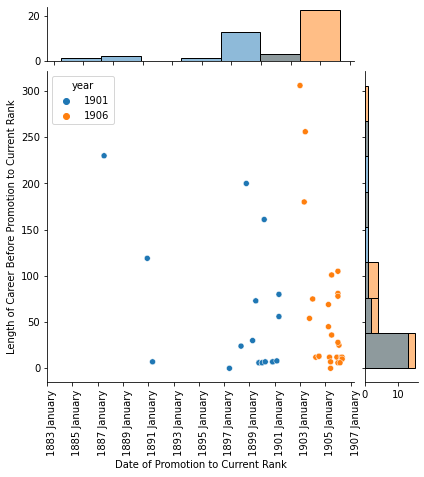

In [13]:
atKch1901 = promoData[0][promoData[0]["1901 location/last port"] == "Kiaochow"]
atKch1906 = promoData[1][promoData[1]["1906 location/last port"] == "Kiaochow"]
kchCombinedA = pd.DataFrame({'promodate' : atKch1901["1901 date promoted to primary"],
                            'careerlength' : atKch1901["1901 promotion wait"],
                            'job' : atKch1901["1901 primary rank"]})
kchCombinedB = pd.DataFrame({'promodate' : atKch1906["1906 date promoted to primary"],
                            'careerlength' : atKch1906["1906 promotion wait"],
                            'job' : atKch1906["1906 primary rank"]})
kiaochowCombined = pd.concat([kchCombinedA.assign(year="1901"), kchCombinedB.assign(year="1906")])

summary = GraphAndTest(data=kiaochowCombined, x="promodate", y="careerlength", hue="year", ax_rank="Current Rank")
summary.rankSum() #"greater" = is 1901 greater than 1906?

[230, 161, 24, 0]
[306, 12, 36, 25, 0]
With continuity correction: MannwhitneyuResult(statistic=10.5, pvalue=1.0)
Without continuity correction: MannwhitneyuResult(statistic=10.5, pvalue=0.9021165931072543)


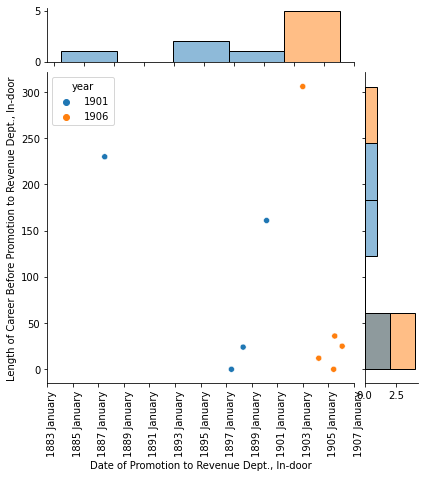

[119, 7, 200, 73]
[180, 256, 105, 101, 75, 54, 78, 69]
With continuity correction: MannwhitneyuResult(statistic=15.0, pvalue=0.9323243733483333)
Without continuity correction: MannwhitneyuResult(statistic=15.0, pvalue=0.865134745405447)


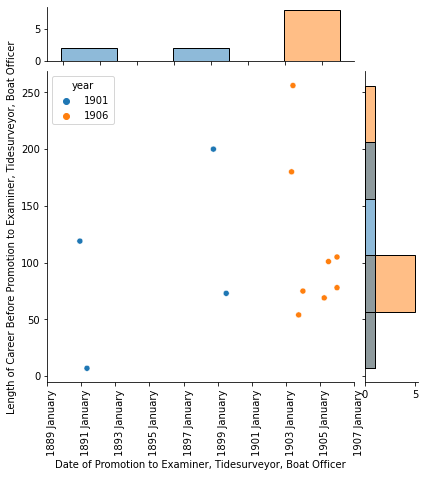

[80, 56, 30, 6, 6, 6, 6, 6, 7, 7, 7, 8]
[81, 45, 28, 13, 13, 12, 7, 12, 12, 12, 10, 6, 6]
With continuity correction: MannwhitneyuResult(statistic=50.5, pvalue=0.13600132003404303)
Without continuity correction: MannwhitneyuResult(statistic=50.5, pvalue=0.12889932465592338)


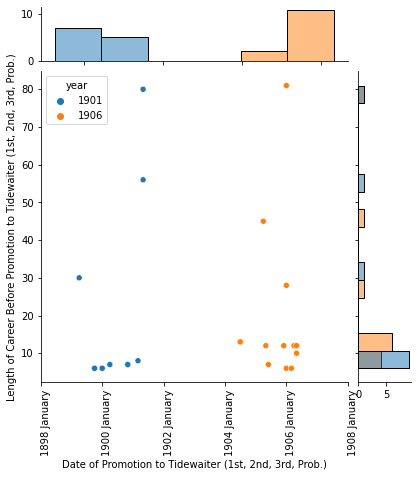

In [14]:
def aggregateJobs(job):
    indoorJobs = ["Commissioner", 'Deputy Commissioner', 'Acting Deputy Commissioner', 'First Assistant, A', 'First Assistant, B', "Second Assistant, B", 'Third Assistant, B', 'Third Assistant, A', "Fourth Assistant, A", "Fourth Assistant, B", 'Chief Assistant', "Chief Assistant, B", "Second Assistant, A", "Fourth Assistant, C", 'Clerk']
    exam_survey = ['Chief Examiner', "Examiner", "Assistant Examiner","Assistant Tidesurveyor", 'Boat Officer']
    tides = ["First Class Tidewaiter","Second Class Tidewaiter","Third Class Tidewaiter","Probationary Tidewaiter", 'Chief Tidesurveyor', 'Tidesurveyor']

    if(job in indoorJobs):
        return "Revenue Dept., In-door"
    elif(job in exam_survey):
        return "Examiner, Tidesurveyor, Boat Officer"
    elif(job in tides):
        return "Tidewaiter (1st, 2nd, 3rd, Prob.)"
    else:
        return job
kiaochowCombined.to_csv("alterationCheck.csv")
kiaochowCombined.loc[:,"job"] = kiaochowCombined.loc[:, "job"].apply(aggregateJobs)

for i in kiaochowCombined["job"].unique():
    promotionsDatasub = kiaochowCombined[kiaochowCombined["job"] == i]
    summary = GraphAndTest(promotionsDatasub, x="promodate", y="careerlength", hue="year", ax_rank=i)
    summary.rankSum() #, corrList=["1901","1906"],colorList=["#1f77b4","C1"])


C:\Users\boopa\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\boopa\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
['Revenue Dept., In-door' 'Tidewaiter (1st, 2nd, 3rd, Prob.)'
 'Examiner, Tidesurveyor, Boat Officer']
Population median: 97
[230, 161]
n = 4, k1 = 2, k2 = 2


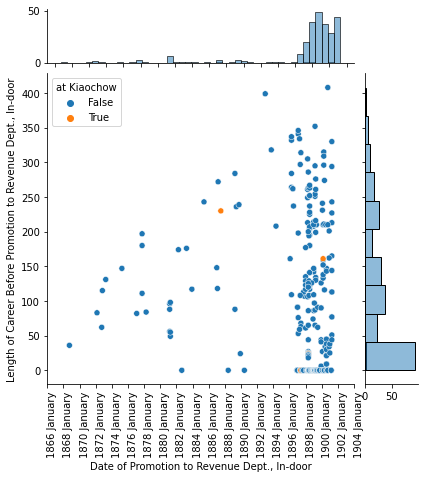

Population median: 7
[80, 56, 30, 8]
n = 12, k1 = 4, k2 = 8
0.19384765625000006


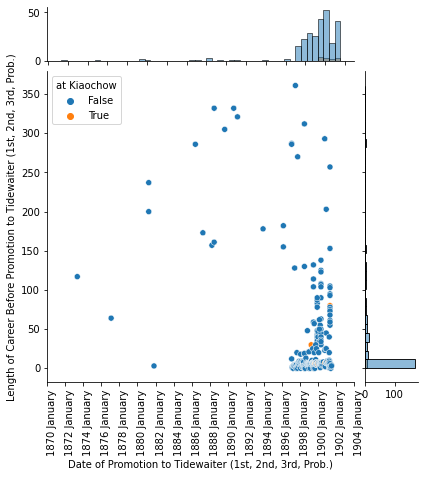

Population median: 141
[200]
n = 4, k1 = 1, k2 = 3
0.3125


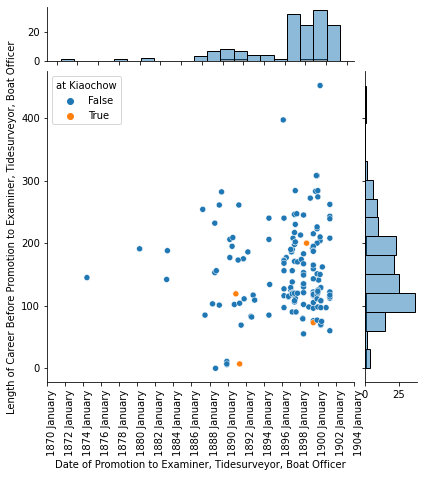

In [15]:
promoData[0].loc[:,"1901 primary rank"] = promoData[0].loc[:, "1901 primary rank"].apply(aggregateJobs)
print(promoData[0]["1901 primary rank"].unique())
promoData[0].loc[:, "at Kiaochow"] = promoData[0].loc[:,"1901 location/last port"] == "Kiaochow"
for i in promoData[0]["1901 primary rank"].unique():
    mask = promoData[0]["1901 primary rank"] == i
    promotionsDatasub = promoData[0][mask]
    summary = GraphAndTest(promotionsDatasub, x="1901 date promoted to primary", y="1901 promotion wait", hue="at Kiaochow", ax_rank=i) #corrList=[True, False], colorList=["#ff7f0e", "C0"])
    summary.signTest([True], "less")

In [16]:
axes = sns.JointGrid(data = promotionsDE,
        x = "1 jul 1901, date appointed to present rank",
        y = "1901 promotion wait", 
        hue = "1 jul 1901, primary rank",
        #marker="+",
        #marginal_ticks = True #PathCollection doesn't have these properties?
        #kind='hist', 
        )
axes.set_axis_labels(xlabel="Date First Hired To Service",
                    ylabel="Length of Career Before Promotion to Current Rank")
axes.plot(sns.scatterplot, sns.histplot)
axes = sns.JointGrid(data = promotionsDE,
        x = "1 jul 1901, date appointed to present rank",
        y = "1901 promotion wait", 
        hue = "1 jul 1901, location/last port",
        #marker="+",
        #marginal_ticks = True #PathCollection doesn't have these properties?
        #kind='hist', 
        )
axes.set_axis_labels(xlabel="Date First Hired To Service",
                    ylabel="Length of Career Before Promotion to Current Rank")
axes.plot(sns.scatterplot, sns.histplot)

# promotionsByNat = []
# for i in promotionsData["nationality"].unique():
#     mask = promotionsData["nationality"] == i
#     promotionsByNat.append(promotionsData[mask])

# if len(axes.get_xticklabels()) > 15:
#     for ind, label in enumerate(axes.get_xticklabels()):
#         if ind % 2 == 1:  # every odd-index label (these labels are even #s though) is kept
#             label.set_visible(True)
#         else:
#             label.set_visible(False)

#maskDE = promotionsData["nationality"] == "German"
#promotionsDE = promotionsData[maskDE]

#print(promotionsDE["1 jul 1901, primary rank"].unique())
#print(customsData.columns) 
    #Index(['name', 'nationality', 'first hired', '1 jul 1901, primary rank',
        #'1 jul 1901, date appointed to present rank',
        #'1 jul 1901, secondary job', '1 jul 1901, date appointed to job',
        #'1 jul 1901, other details', '1 jul 1901, location/last port',
        #'1 jul 1901, on leave?', '1 jul 1905, job', '1 jul 1905, location'],
        #dtype='object')
#print(customsData.head(3))
#print(customsData.tail(5))
#print(customsData.get("1 jul 1901, primary rank").unique())

#filter out all entries with Kiaochow as loc/last port; only way to filter is boolean indexing
#bitwise & | for some reason can do elementwise unification of two bool arrays
#atKiaochowB = (promotionsData["1 jul 1901, location/last port"] == "Kiaochow") 
#isSurgeon = customsData["1 jul 1901, primary rank"] == "Surgeon" 
#print(customsData[atKiaochowA])
#print(promotionsData[atKiaochowB])
#print(customsData[atKiaochow].get("1 jul 1901, primary rank").value_counts())

NameError: name 'promotionsDE' is not defined

In [37]:
with pl.style.context(stylesheet1):
    pl.plot(os,phirs, label = "PDF, real observations")
            
pl.hist(obs_false,intervals_f, label="Observations classified as hallucinations", color = 'orange')
stylesheet3 = {
    #"axes.titlesize" : 24,
    "axes.labelsize" : 20,
    #lines.linewidth : 3,
    #"lines.markersize" : 10,
    "xtick.labelsize" : 20,
    "ytick.labelsize" : 20,
    "figure.figsize" : (8.5, 5),
    'font.family' : 'serif',
    #'font.weight' : 50,
    #'font.serif' : ['Times New Roman'],
}

IndentationError: unexpected indent (<ipython-input-37-f5e15aee2ede>, line 52)

In [ ]:
#old heatmaps

#round values to make graph clearer
promotionsData.loc[:,"1 jul 1901, date appointed to present rank"] = promotionsData.loc[
    :,"1 jul 1901, date appointed to present rank"].apply(lambda x: x - (x % 12))
promotionsData.loc[:,"1901 promotion wait"] = promotionsData.loc[
    :,"1901 promotion wait"].apply(lambda x: x - (x % 12))


groupedPromos = promotionsData.groupby(['1901 promotion wait', '1 jul 1901, date appointed to present rank'])
groupedCounts = groupedPromos["name"].nunique()
countTable = groupedCounts.loc[:,:].reset_index().pivot(index='1901 promotion wait', 
    columns='1 jul 1901, date appointed to present rank', values='name')
countTable.fillna(0, inplace=True)
countTable = countTable.reindex(range(np.min(countTable.index),np.max(countTable.index), 12), axis=0, fill_value=0)
countTable = countTable.reindex(range(np.min(countTable.columns),np.max(countTable.columns), 12), axis=1, fill_value=0)#.astype(int)

countTable.to_csv("countTable.csv")
print("Shape:" + str(countTable.shape))

fig, ax = plt.subplots()
im = ax.imshow(countTable)

# We want to show all ticks...
ax.set_xticks(np.arange(0, 33))
ax.set_yticks(np.arange(0, 43))
# ... and label them with the respective list entries
ax.set_xticklabels(map(numToDate, countTable.columns, np.repeat([True], countTable.shape[1])))
ax.set_yticklabels(countTable.index)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
ax.xaxis.set_ticks_position('top')
# Loop over data dimensions and create text annotations.
#for i in range(1, countTable.index):
#    for j in countTable.keys():
#        text = ax.text(i, j, countTable[i, j], ha="center", va="center", color="w")

#ax.set_title("Harvest of local farmers (in tons/year)")
#fig.tight_layout()
plt.show()